# Illustration of Data Balancing Procedure

In this Jupyter notebook, we provide a lightweight example that shows the effect of data balancing iterations on a simulated joint distribution.

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import numpy as np
import pandas as pd
import scipy

import warnings
warnings.filterwarnings('ignore') # deprecation warnings from seaborn internals

In [3]:
import matplotlib as mpl

mpl.rcParams['lines.linewidth'] = 4
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams["axes.labelsize"] = 20
mpl.rcParams['legend.fontsize'] = 33
mpl.rcParams['axes.titlesize'] = 32
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

data_color = "dodgerblue"
true_color = "lightsalmon"
title_size = 20

The method can be implemented with a few lines, as seen in the `data_balance` function below.

In [4]:
def count_freq(X, Y, sizes):
    """
    Compute the histogram/joint probability mass function of integer-valued paired data.
    """
    pairs = list(zip(X, Y))
    ind, count = np.unique(pairs, axis=0, return_counts=True)
    cmat = np.zeros(sizes)
    cmat[ind[:, 0], ind[:, 1]] = count
    return cmat / len(pairs)


def data_balance(X, Y, marginals, num_iter):
    """
    Apply `num_iter` balancing iterations to empirical data and return the sequence of joint distributions.
    """
    pmat = count_freq(X, Y, (len(marginals[0]), len(marginals[1])))
    if np.sum(np.sum(pmat, axis=1) == 0) + np.sum(np.sum(pmat, axis=0) == 0) > 0:
        raise RuntimeError(
            "Missing mass in this sample. Try a larger sample size.")
        
    est = [pmat.copy()]
    for i in range(1, num_iter):
        pmat = (marginals[0] / np.sum(pmat, axis=1)).reshape(-1, 1) * pmat
        pmat = pmat * (marginals[1] / np.sum(pmat, axis=0))
        est.append(pmat.copy())
    return est

## Simulate Data

We first simulate a joint data distribution by specifying $P_X$ and $P_{Y|X}$.

In [5]:
np.random.seed(123)

# set true distribution
m = 50
bias = 0.5
transition = np.random.rand(m, m)
transition = np.arange(m + 1)[1:][:, None] * np.arange(m + 1)[1:][None, :] + bias * m * np.ones(shape=(m, m))
transition = transition / transition.sum(axis=0)[None, :]
weight = 0.8
nums = np.arange(m)
p = 0.7
px = weight * np.exp(np.log(scipy.special.binom(m-1, nums)) + nums * np.log(p) + (m - 1 - nums) * np.log(1 - p)) + (1 - weight) * np.ones(m) / m
prob = transition * px[None, :]
py = prob.sum(axis=1)
marginals = (py, px) # each marginal is of size m

Below, we plot the true marginal distributions $(P_X, P_Y)$ in the form of histograms.

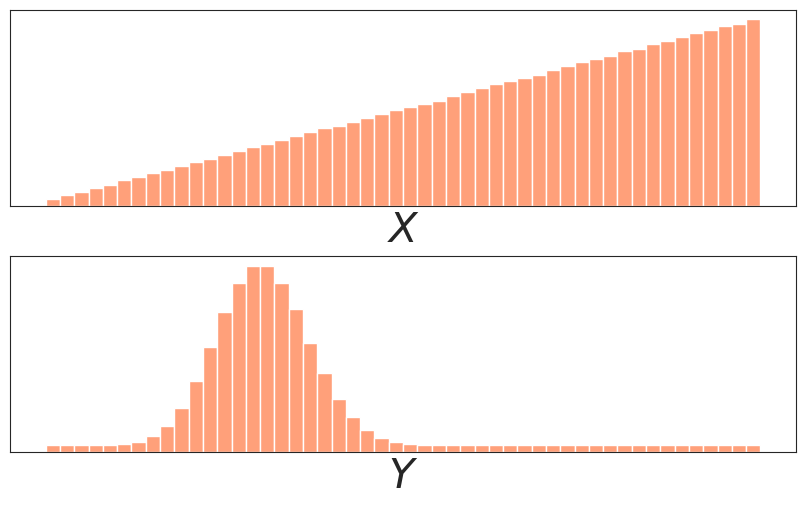

In [6]:
sns.set_style("white")
edges=False
color = true_color
fig, ax = plt.subplots(2, 1, figsize=(8, 5))

# sample original data
n = 1000000
data = np.random.choice(m ** 2, size=(n,), p=prob.reshape(-1))
x = data // m
y = data % m
num_iter = 4

n = len(x)
m = len(np.unique(x))

# flip X to match orientation
if edges:
    ax[0].hist(x, color=color, bins=m, edgecolor="k")
    ax[1].hist(-y, color=color, bins=m, edgecolor="k")
else:
    ax[0].hist(x, color=color, bins=m)
    ax[1].hist(-y, color=color, bins=m)
    
ax[0].set_xticks([])
ax[1].set_xticks([])
ax[0].set_yticks([])
ax[1].set_yticks([])

ax[0].set_xlabel(r"$X$", fontsize=30)
ax[1].set_xlabel(r"$Y$", fontsize=30)

fig.tight_layout(pad=0.5)
plt.show()

## Balance the Empirical Distribution

We then sample data from this distribution to generate a dataset of $(X_1, Y_1), \ldots, (X_n, Y_n)$ of iid pairs.

In [7]:
# sample original data
n = 1000
data = np.random.choice(m ** 2, size=(n,), p=prob.reshape(-1))
x = data // m
y = data % m
num_iter = 4

# get empirical distribution and balanced  estimators
est = data_balance(x, y, marginals, num_iter)

In [8]:
# seaborn joint plot requires data, so we generate a large dataset from a joint pmf
def generate(jpmf, n=1000000):
    np.random.seed(123)
    data = np.random.choice(m ** 2, size=(n,), p=jpmf.reshape(-1))
    x = data // m
    y = data % m
    return pd.DataFrame({'x': x, 'y': y})

We then visualize each iteration of the procedure.

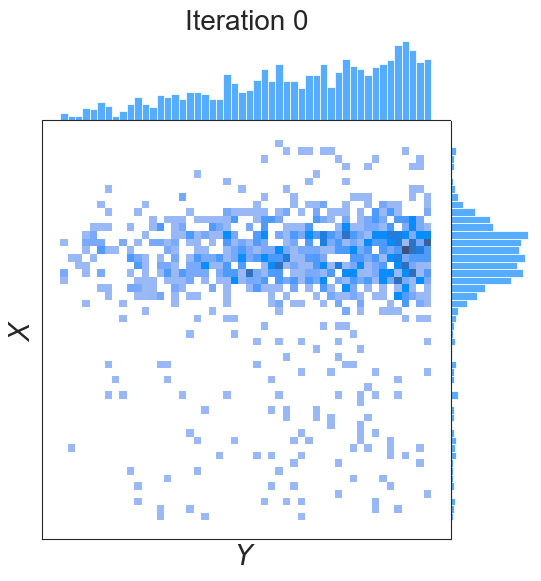

In [9]:
iteration = 0

jpmf = est[iteration]
df = generate(jpmf)

g = sns.jointplot(data=df, x='x', y='y', kind='hist', bins=(m, m), color=data_color)
g.ax_joint.set_xticks([])
g.ax_joint.set_yticks([])
g.ax_joint.set_xlabel(r"$Y$")
g.ax_joint.set_ylabel(r"$X$")

g.fig.subplots_adjust(hspace=0.01, wspace=0.01)
g.fig.suptitle(f"Iteration {iteration}", y=1.02, fontsize=title_size)

plt.show()

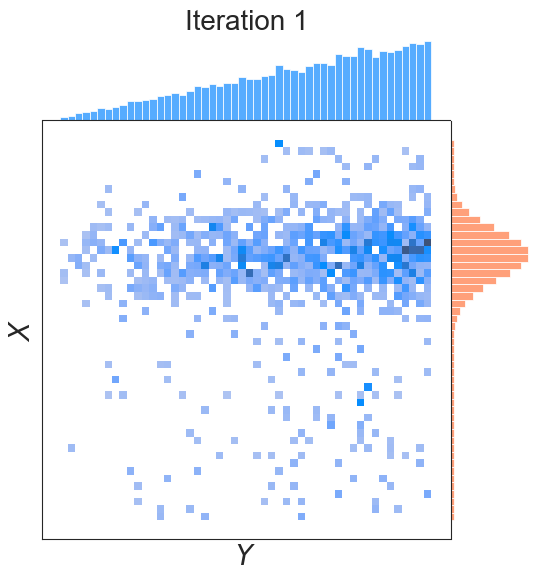

In [10]:
iteration = 1

joint = est[iteration]
df = generate(joint)

g = sns.jointplot(data=df, x='x', y='y', kind='hist', bins=(m, m), color=data_color)
g.ax_joint.set_xticks([])
g.ax_joint.set_yticks([])
g.ax_joint.set_xlabel(r"$Y$")
g.ax_joint.set_ylabel(r"$X$")

for patch in g.ax_marg_y.patches:
    patch.set_facecolor(true_color)

g.fig.subplots_adjust(hspace=0.01, wspace=0.01)
g.fig.suptitle(f"Iteration {iteration}", y=1.02, fontsize=title_size)

plt.show()

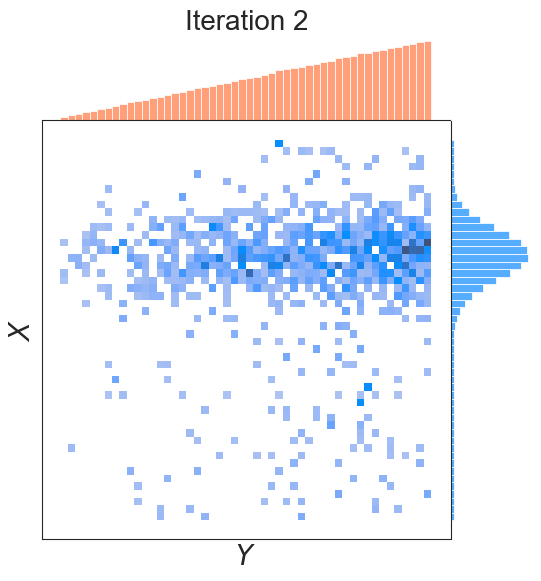

In [11]:
iteration = 2
title_size = 20

joint = est[iteration]
df = generate(joint)

g = sns.jointplot(data=df, x='x', y='y', kind='hist', bins=(m, m), color=data_color)
g.ax_joint.set_xticks([])
g.ax_joint.set_yticks([])
g.ax_joint.set_xlabel(r"$Y$")
g.ax_joint.set_ylabel(r"$X$")

for patch in g.ax_marg_x.patches:
    patch.set_facecolor(true_color)

g.fig.subplots_adjust(hspace=0.01, wspace=0.01)
g.fig.suptitle(f"Iteration {iteration}", y=1.02, fontsize=title_size)

plt.show()